# Reactive MD
Here we show how to use neural NEB, eigenvector following, and reactive MD to simulate dynamics after a transition state.

In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.insert(0, "..")
sys.path.insert(0, "../..")

In [2]:
import os
import sys
import django
import pprint
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt


%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
from scipy.interpolate import interp1d

import torch

In [3]:
from ase.io import read
from ase.neb import NEB, SingleCalculatorNEB, NEBTools
from ase.optimize import MDMin, BFGS, QuasiNewton, FIRE
from ase.md.langevin import *
from ase.md.verlet import *
from ase import Atoms
from ase.units import Bohr,Rydberg,kJ,kB,fs,Hartree,mol,kcal,second
from ase.vibrations import Vibrations


from nff.io.ase import NeuralFF, AtomsBatch
from nff.data import Dataset
from nff.train import load_model, evaluate
from nff.md.utils import *
import nff.utils.constants as const
from nff.nn.tensorgrad import *

from nff.reactive_tools import *

You need to install the group's fork of aRMSD and put it in your path https://github.mit.edu/MLMat/aRMSD


In [4]:
from rdkit import RDLogger
import logging
import re
from rdkit.Chem.AllChem import MolFromSmiles, MolToSmiles, ReactionFromSmarts
from rdkit.Chem import AllChem as Chem
PERIODICTABLE = Chem.GetPeriodicTable()

## Specify the reactive GCNN FF

In [5]:
nff_dir = '../models/diels_alder/'
nff = NeuralFF.from_file(nff_dir, device='cuda:1')

/home/saxelrod/miniconda3/envs/htvs/lib/python3.7/site-packages/torch/serialization.py:671: SourceChangeWarning: source code of class 'nff.nn.models.schnet.SchNet' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/saxelrod/miniconda3/envs/htvs/lib/python3.7/site-packages/torch/serialization.py:671: SourceChangeWarning: source code of class 'torch.nn.modules.sparse.Embedding' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/saxelrod/miniconda3/envs/htvs/lib/python3.7/site-packages/torch/serialization.py:671: SourceChangeWarning: source code of class 'torch.nn.modules.container.ModuleList' has changed. you can retrieve 

## Neural NEB

In [6]:
import nglview

view_rxt = nglview.show_ase(xyz_to_ase_atoms("data/reactive_xyzs/da_r_m062x_def2svp.xyz"))
view_pdt = nglview.show_ase(xyz_to_ase_atoms("data/reactive_xyzs/da_p_m062x_def2svp.xyz"))

In [7]:
view_rxt

NGLWidget()

In [8]:
view_pdt

NGLWidget()

In [9]:
rxn_name = 'diels-alder'

images = neural_neb_ase('data/reactive_xyzs/da_r_m062x_def2svp.xyz', 
                        'data/reactive_xyzs/da_p_m062x_def2svp.xyz', 
                         nff_dir, 
                         rxn_name,
                         steps=100, 
                         n_images=24, 
                         fmax=0.004)

/home/saxelrod/miniconda3/envs/htvs/lib/python3.7/site-packages/ase/utils/__init__.py:62: FutureWarning: SingleCalculatorNEB is deprecated. Please use NEB(allow_shared_calculator=True) instead.
  warnings.warn(warning)
/home/saxelrod/miniconda3/envs/htvs/lib/python3.7/site-packages/ase/utils/__init__.py:62: FutureWarning: Please use NEB's interpolate(method='idpp') method or directly call the idpp_interpolate function from ase.neb
  warnings.warn(warning)
/home/saxelrod/miniconda3/envs/htvs/lib/python3.7/site-packages/torch/serialization.py:671: SourceChangeWarning: source code of class 'nff.nn.models.schnet.SchNet' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/saxelrod/miniconda3/envs/htvs/lib/python3.7/site-packages/torch/serialization.py:671: SourceChangeWarning: source code of class 'torch.nn.m

      Step     Time          Energy         fmax
BFGS:    0 12:43:22       12.162097        5.5434
BFGS:    1 12:43:23       11.511966        3.7255
BFGS:    2 12:43:26       11.075717        5.2384
BFGS:    3 12:43:27       10.679111        3.7754
BFGS:    4 12:43:29       10.384745        4.3355
BFGS:    5 12:43:32       10.259050        3.6010
BFGS:    6 12:43:34       10.084239        1.5592
BFGS:    7 12:43:35        9.854200        3.1848
BFGS:    8 12:43:37        9.717394        3.8352
BFGS:    9 12:43:39        9.582299        1.8481
BFGS:   10 12:43:41        9.459876        1.5021
BFGS:   11 12:43:43        9.373620        1.5807
BFGS:   12 12:43:45        9.271419        2.0368
BFGS:   13 12:43:46        9.170526        1.8296
BFGS:   14 12:43:50        9.115574        0.8439
BFGS:   15 12:43:52        9.051316        1.3778
BFGS:   16 12:43:54        8.986056        1.3315
BFGS:   17 12:43:56        8.923494        1.4458
BFGS:   18 12:43:58        8.856803        1.5467
B

In [10]:
energies = []

for image in images:
    image = AtomsBatch(positions=torch.tensor(image.positions), 
                       numbers=torch.tensor(image.numbers),
                       cutoff=5.5, directed=True)
    
    image.set_calculator(nff)
    energies.append(image.get_potential_energy())
    
    highest_image_ind = np.argmax(np.array(energies))

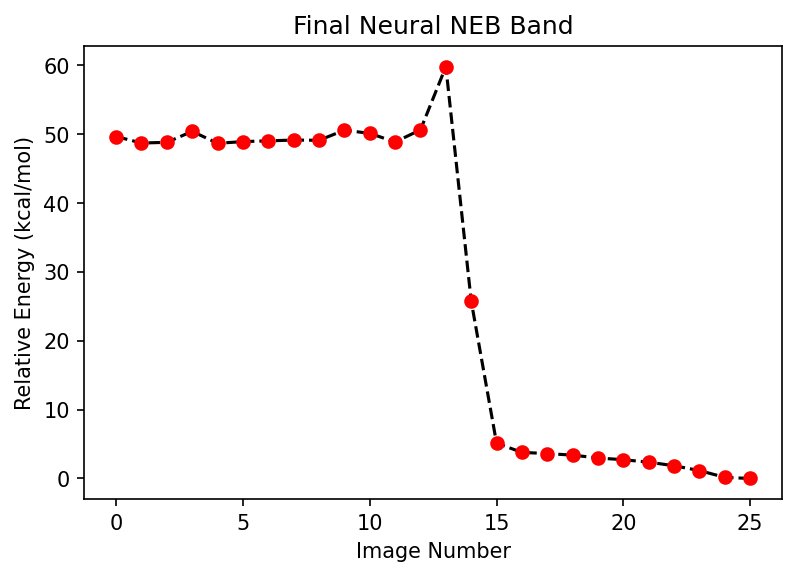

In [11]:
mpl.rcParams['figure.dpi'] = 150

rel_energy = []
for i in range(len(energies)):
    rel_energy.append((energies[i]-np.array(energies).min()) / (kcal/mol))

iteration = [i for i in range(len(energies))]
plt.scatter(iteration, rel_energy, c="r", label='image', zorder=2)

plt.plot(iteration, rel_energy, '--', c="black", label='image', zorder=1)


plt.title("Final Neural NEB Band")
plt.xlabel("Image Number")
plt.ylabel("Relative Energy (kcal/mol)")

plt.show()

In [12]:
ev_atoms = images[highest_image_ind].copy()

ev_atoms = AtomsBatch(ev_atoms, cutoff=5.5, directed=True)

ev_atoms.set_calculator(nff)

## Eigenvector Following from Neural NEB Guess

In [13]:
ev_atoms.calc

In [14]:
from ase import Atoms
from ase.calculators.emt import EMT
from ase.optimize import BFGS
from ase.vibrations import Vibrations
n2 = Atoms('N2', [(0, 0, 0), (0, 0, 1.1)],
           calculator=EMT())
BFGS(n2).run(fmax=0.01)
vib = Vibrations(n2)
vib.run()
vib.summary()

      Step     Time          Energy         fmax
BFGS:    0 12:46:58        0.440344        3.2518
BFGS:    1 12:46:58        0.264361        0.3475
BFGS:    2 12:46:58        0.262860        0.0805
BFGS:    3 12:46:58        0.262777        0.0015
---------------------
  #    meV     cm^-1
---------------------
  0    0.0       0.0
  1    0.0       0.0
  2    0.0       0.0
  3    1.4      11.5
  4    1.4      11.5
  5  152.7    1231.3
---------------------
Zero-point energy: 0.078 eV


In [16]:
import shutil

# if the `vib` folder is left over from a previous run, then we need to remove it
if os.path.isdir('vib'):
    if os.path.isdir('vib_backup'):
        shutil.rmtree('vib_backup')
    shutil.move('vib', 'vib_backup')
    
device="cuda:1"

xyz, grad, xyz_all, rmslist, maxlist = ev_run(ev_atoms, 
                                              nff_dir=nff_dir, 
                                              maxstepsize=0.005, 
                                              maxstep=1000, 
                                              convergence=0.03, 
                                              device=device, 
                                              method='Powell')

Calculating Numerical Hessian using ASE
---------------------
  #    meV     cm^-1
---------------------
  0   10.4i     83.8i
  1    7.4i     59.7i
  2    4.9i     39.6i
  3    2.7i     21.5i
  4    0.5i      4.0i
  5    0.4i      3.0i
  6    0.6       5.2
  7   14.9     120.0
  8   26.8     216.5
  9   33.2     267.8
 10   40.5     326.8
 11   41.1     331.6
 12   46.0     370.8
 13   47.3     381.3
 14   51.4     414.2
 15   62.9     507.0
 16   65.7     529.5
 17   66.3     534.8
 18   77.5     625.4
 19   87.4     705.1
 20   91.8     740.3
 21   98.1     791.2
 22  103.5     834.5
 23  107.6     868.2
 24  110.5     891.0
 25  115.1     928.7
 26  119.5     964.2
 27  122.6     988.7
 28  123.6     997.0
 29  127.6    1029.2
 30  132.5    1068.5
 31  134.6    1085.5
 32  138.0    1112.7
 33  151.7    1223.8
 34  154.1    1242.9
 35  164.0    1322.5
 36  168.1    1355.6
 37  172.8    1393.6
 38  182.3    1470.4
 39  187.6    1513.4
 40  193.8    1563.4
 41  204.2    1647.0
 42  20

../nff/reactive_tools/ev_following.py:56: UserWarning: torch.eig is deprecated in favor of torch.linalg.eig and will be removed in a future PyTorch release.
torch.linalg.eig returns complex tensors of dtype cfloat or cdouble rather than real tensors mimicking complex tensors.
L, _ = torch.eig(A)
should be replaced with
L_complex = torch.linalg.eigvals(A)
and
L, V = torch.eig(A, eigenvectors=True)
should be replaced with
L_complex, V_complex = torch.linalg.eig(A) (Triggered internally at  /pytorch/aten/src/ATen/native/BatchLinearAlgebra.cpp:2897.)
  eigenvalues, eigvecs = torch.eig(hessian, eigenvectors=True)
../nff/reactive_tools/ev_following.py:71: UserWarning: torch.symeig is deprecated in favor of torch.linalg.eigh and will be removed in a future PyTorch release.
The default behavior has changed from using the upper triangular portion of the matrix by default to using the lower triangular portion.
L, _ = torch.symeig(A, upper=upper)
should be replaced with
L = torch.linalg.eigvalsh(

RMS: 0.06620920449495316, MAX: 0.27152884006500244
RMS: 0.06121966242790222, MAX: 0.25542813539505005
RMS: 0.05643753707408905, MAX: 0.239432230591774
RMS: 0.05191968008875847, MAX: 0.22319763898849487
RMS: 0.04803716018795967, MAX: 0.20730054378509521
RMS: 0.04439105838537216, MAX: 0.19162698090076447
RMS: 0.041213128715753555, MAX: 0.17703846096992493
RMS: 0.03856250271201134, MAX: 0.16404220461845398
RMS: 0.036600835621356964, MAX: 0.15354403853416443
RMS: 0.035170216113328934, MAX: 0.14514918625354767
RMS: 0.03252890706062317, MAX: 0.13326454162597656
RMS: 0.030410561710596085, MAX: 0.12642180919647217
RMS: 0.02843380905687809, MAX: 0.12037171423435211
RMS: 0.026573775336146355, MAX: 0.11441071331501007
RMS: 0.025284409523010254, MAX: 0.10961282253265381
RMS: 0.02399936504662037, MAX: 0.10577311366796494
RMS: 0.02325434423983097, MAX: 0.10347277671098709
RMS: 0.022115744650363922, MAX: 0.10031195729970932
RMS: 0.02130136638879776, MAX: 0.09768839925527573
RMS: 0.020419670268893242,

RMS: 0.01007477194070816, MAX: 0.05922659859061241
RMS: 0.009920481592416763, MAX: 0.05955827981233597
RMS: 0.009865008294582367, MAX: 0.0600823350250721
RMS: 0.009862689301371574, MAX: 0.060851458460092545
RMS: 0.009952165186405182, MAX: 0.06250379234552383
RMS: 0.00993715412914753, MAX: 0.061821285635232925
RMS: 0.010227350518107414, MAX: 0.06233377382159233
RMS: 0.010079567320644855, MAX: 0.06262092292308807
RMS: 0.010048671625554562, MAX: 0.05998750030994415
RMS: 0.010203293524682522, MAX: 0.0598757229745388
RMS: 0.009948610328137875, MAX: 0.05954715982079506
RMS: 0.01013322826474905, MAX: 0.05936242267489433
RMS: 0.009939882904291153, MAX: 0.059296321123838425
RMS: 0.009855436161160469, MAX: 0.05960400402545929
RMS: 0.009842387400567532, MAX: 0.06033708155155182
RMS: 0.009910042397677898, MAX: 0.06176746264100075
RMS: 0.009980369359254837, MAX: 0.061721570789813995
RMS: 0.010047497227787971, MAX: 0.0634678304195404
RMS: 0.010128272697329521, MAX: 0.06253662705421448
RMS: 0.0103987

RMS: 0.010176409967243671, MAX: 0.06005183979868889
RMS: 0.009972989559173584, MAX: 0.059928569942712784
RMS: 0.0098098274320364, MAX: 0.05991528928279877
RMS: 0.00966787151992321, MAX: 0.05994560196995735
RMS: 0.00954500399529934, MAX: 0.059991203248500824
RMS: 0.009435777552425861, MAX: 0.059882231056690216
RMS: 0.009522724896669388, MAX: 0.059713006019592285
RMS: 0.0095148216933012, MAX: 0.06069805845618248
RMS: 0.009559595957398415, MAX: 0.06212611123919487
RMS: 0.009715047664940357, MAX: 0.06212398782372475
RMS: 0.009876406751573086, MAX: 0.06389728933572769
RMS: 0.00976764690130949, MAX: 0.06097443401813507
RMS: 0.010004217736423016, MAX: 0.06074770539999008
RMS: 0.009744173847138882, MAX: 0.06031356751918793
RMS: 0.009917614981532097, MAX: 0.059943169355392456
RMS: 0.00976004358381033, MAX: 0.06021348014473915
RMS: 0.009645349346101284, MAX: 0.060519639402627945
RMS: 0.009533984586596489, MAX: 0.0607231967151165
RMS: 0.009574385359883308, MAX: 0.05953415483236313
RMS: 0.00951058

RMS: 0.009596114046871662, MAX: 0.06048007681965828
RMS: 0.009929372929036617, MAX: 0.061676446348428726
RMS: 0.009830943308770657, MAX: 0.06245853006839752
RMS: 0.009655636735260487, MAX: 0.06203995272517204
RMS: 0.009682951495051384, MAX: 0.06074663996696472
RMS: 0.01001916266977787, MAX: 0.061580806970596313
RMS: 0.00991897564381361, MAX: 0.06246402487158775
RMS: 0.00975022092461586, MAX: 0.062224119901657104
RMS: 0.009747268632054329, MAX: 0.06058260798454285
RMS: 0.010064233094453812, MAX: 0.061232298612594604
RMS: 0.009958169423043728, MAX: 0.062065742909908295
RMS: 0.009824768640100956, MAX: 0.06216117739677429
RMS: 0.009781266562640667, MAX: 0.06014150753617287
RMS: 0.010060888715088367, MAX: 0.06064100190997124
RMS: 0.010292676277458668, MAX: 0.06057346984744072
RMS: 0.010070789605379105, MAX: 0.06046329811215401
RMS: 0.009872893802821636, MAX: 0.060272496193647385
RMS: 0.010064060799777508, MAX: 0.06039249151945114
RMS: 0.009860883466899395, MAX: 0.05994678661227226
RMS: 0.00

RMS: 0.010020486079156399, MAX: 0.0600329227745533
RMS: 0.009874849580228329, MAX: 0.060023315250873566
RMS: 0.009765872731804848, MAX: 0.06025313958525658
RMS: 0.00971263088285923, MAX: 0.06081121042370796
RMS: 0.009731286205351353, MAX: 0.062081534415483475
RMS: 0.009869230911135674, MAX: 0.06242367997765541
RMS: 0.00987551361322403, MAX: 0.063746877014637
RMS: 0.009958462789654732, MAX: 0.06278222054243088
RMS: 0.010229991748929024, MAX: 0.06284772604703903
RMS: 0.0100465789437294, MAX: 0.06306224316358566
RMS: 0.009966365061700344, MAX: 0.060409560799598694
RMS: 0.010195792652666569, MAX: 0.06052089482545853
RMS: 0.009955011308193207, MAX: 0.06017611548304558
RMS: 0.010152731090784073, MAX: 0.0601067990064621
RMS: 0.00995277613401413, MAX: 0.05992363765835762
RMS: 0.00982762686908245, MAX: 0.060112278908491135
RMS: 0.009757904335856438, MAX: 0.06068628653883934
RMS: 0.009796952828764915, MAX: 0.0619843527674675
RMS: 0.00998768862336874, MAX: 0.06259099394083023
RMS: 0.0099219195544

RMS: 0.010116102173924446, MAX: 0.06121617555618286
RMS: 0.009939787909388542, MAX: 0.06101062893867493
RMS: 0.00976093765348196, MAX: 0.06058330461382866
RMS: 0.009896313771605492, MAX: 0.060193777084350586
RMS: 0.009786534123122692, MAX: 0.060599032789468765
RMS: 0.009738633409142494, MAX: 0.06114189699292183
RMS: 0.009746087715029716, MAX: 0.06200724095106125
RMS: 0.009946493431925774, MAX: 0.06282734870910645
RMS: 0.009881657548248768, MAX: 0.06352679431438446
RMS: 0.009834050200879574, MAX: 0.06141754984855652
RMS: 0.010083037428557873, MAX: 0.06142735108733177
RMS: 0.009859127923846245, MAX: 0.06103949993848801
RMS: 0.009996061213314533, MAX: 0.06007952243089676
RMS: 0.00987961608916521, MAX: 0.060767389833927155
RMS: 0.009826402179896832, MAX: 0.06148775294423103
RMS: 0.009820263832807541, MAX: 0.06247758865356445
RMS: 0.009946459904313087, MAX: 0.06231683865189552
RMS: 0.010033102706074715, MAX: 0.06408201158046722
RMS: 0.010056714527308941, MAX: 0.06246316805481911
RMS: 0.0103

RMS: 0.009864816442131996, MAX: 0.06244379281997681
RMS: 0.009992021135985851, MAX: 0.06426191329956055
RMS: 0.009931783191859722, MAX: 0.06254930794239044
RMS: 0.010156000964343548, MAX: 0.06239235773682594
RMS: 0.009948967024683952, MAX: 0.062245242297649384
RMS: 0.009981323033571243, MAX: 0.060511622577905655
RMS: 0.010277340188622475, MAX: 0.061433784663677216
RMS: 0.010225038975477219, MAX: 0.06242319196462631
RMS: 0.010079964064061642, MAX: 0.06265082955360413
RMS: 0.00987144187092781, MAX: 0.062215227633714676
RMS: 0.009877173230051994, MAX: 0.060740549117326736
RMS: 0.010010688565671444, MAX: 0.061914388090372086
RMS: 0.009997613728046417, MAX: 0.06290887296199799
RMS: 0.010265100747346878, MAX: 0.06330351531505585
RMS: 0.01017836295068264, MAX: 0.06388376653194427
RMS: 0.00997877772897482, MAX: 0.060839857906103134
RMS: 0.010235290043056011, MAX: 0.060711681842803955
RMS: 0.010014591738581657, MAX: 0.06041760742664337
RMS: 0.010219893418252468, MAX: 0.06025391072034836
RMS: 0.

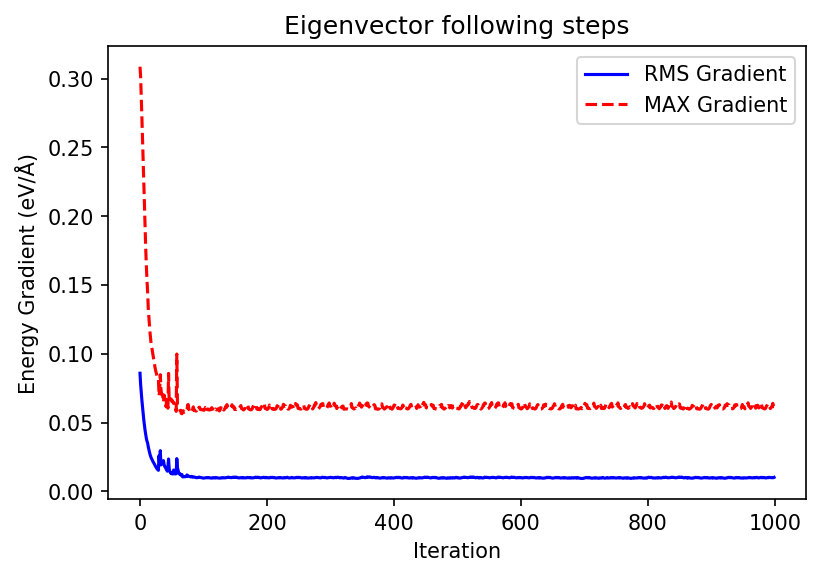

In [17]:
mpl.rcParams['figure.dpi'] = 150

iteration = [i for i in range(len(rmslist))]

rmslist1 = [float(i) for i in rmslist]
maxlist1 = [float(i) for i in maxlist]

plt.plot(iteration, rmslist1, '-', c="b", label='RMS Gradient')
plt.plot(iteration, maxlist1, '--', c="r", label='MAX Gradient')

plt.title("Eigenvector following steps")
plt.xlabel("Iteration")
plt.ylabel("Energy Gradient (eV/Å)")
plt.legend(loc='upper right')

plt.show()

## Neural Hessian of the DFT refined TS structure

We used the output geometry of the neural eigenvector following algorithm and refined it with M06-2X/def2-SVP level of theory

In [18]:
# M06-2X/def2-SVP quantum mechanical TS coordinates

tsxyzfile = "data/reactive_xyzs/da_ts_m062x_def2svp.xyz"

In [19]:
ts_atoms = AtomsBatch(xyz_to_ase_atoms(tsxyzfile), cutoff=5.5, directed=True)

ts_atoms.set_calculator(nff)

hessian = neural_hessian_ase(ts_atoms)

r = torch.Tensor([PERIODICTABLE.GetAtomicNumber(i) for i in ts_atoms.get_chemical_symbols()]).reshape(-1,len(ts_atoms.get_chemical_symbols()))
xyz = torch.Tensor(ts_atoms.get_positions().reshape(-1,len(ts_atoms.get_positions()),3))

Calculating Numerical Hessian using ASE
---------------------
  #    meV     cm^-1
---------------------
  0   67.7i    546.0i
  1   42.4i    341.7i
  2    4.3i     34.3i
  3    1.9i     15.5i
  4    0.6i      4.8i
  5    0.4i      2.9i
  6    0.1i      1.2i
  7    4.0      32.6
  8   10.8      87.2
  9   23.6     190.7
 10   28.9     232.9
 11   42.2     340.1
 12   45.4     366.4
 13   45.9     370.5
 14   51.2     412.9
 15   57.0     460.1
 16   64.6     520.8
 17   75.8     611.7
 18   79.7     642.8
 19   89.5     721.5
 20   96.2     775.7
 21  101.2     815.9
 22  110.3     889.8
 23  115.6     932.4
 24  117.4     946.7
 25  121.1     976.4
 26  122.9     991.3
 27  126.2    1017.5
 28  132.1    1065.2
 29  132.6    1069.7
 30  139.5    1125.1
 31  143.1    1154.0
 32  145.1    1170.3
 33  147.8    1192.2
 34  155.9    1257.4
 35  161.6    1303.2
 36  174.1    1403.9
 37  174.4    1406.7
 38  180.0    1451.7
 39  183.6    1481.2
 40  190.5    1536.6
 41  200.1    1613.6
 42  2

### Projecting translational and rotational modes

In [20]:
force_constants_J_m_2, proj_vib_freq_cm_1, proj_hessian_eigvec = vib_analy(r.cpu().numpy(),xyz.cpu().numpy(),
                                                                           hessian)

## Reactive Langevin MD

Pairs of Langevin MD trajectories initiated in the vicinity of transition state in the forward and backward directions.

In [21]:
md_params = {
    'T_init': 298.15, # Temperature in K
    'friction': 0.0012, # Langevin friction coefficient
    'time_step': 1 , 
    'thermostat': Langevin, 
    'steps': 500,
    'save_frequency': 1, # Save every n frames
    'nbr_list_update_freq': 5, # Neighbor list update frequency
    'thermo_filename': './thermo1.log', 
    'traj_filename': './atom1.traj',
    'skip': 0
}

### Running *n_traj* pairs of reactive MD

In [22]:
n_traj = 1
device = "cuda:1"

In [23]:
for iteration in range(n_traj):
    
    # Sampling of initial structure and velocities
    
    disp_xyz, vel_plus, vel_minus = reactive_normal_mode_sampling(xyz.cpu().numpy(),
                                                              force_constants_J_m_2, 
                                                              proj_vib_freq_cm_1, 
                                                              proj_hessian_eigvec,
                                                              md_params['T_init'])
    
    for sign in ['minus','plus']:

        reactmdatoms = Atoms(symbols=[PERIODICTABLE.GetElementSymbol(int(i)) for i in list(r.reshape(-1))],
                               positions=torch.Tensor(disp_xyz.reshape(-1,3)),
                               pbc=False)
        
        reactmd_atoms = AtomsBatch(reactmdatoms, cutoff=5.5, directed=True)
        
        nff_ase = NeuralFF.from_file(nff_dir, device=device)
        reactmd_atoms.set_calculator(nff_ase)
        
        if sign == 'minus':            
            vel = vel_minus
        else:            
            vel = vel_plus    
            
        react_nvt = Reactive_Dynamics(reactmd_atoms, vel, md_params)
        react_nvt.run()

        react_nvt.save_as_xyz("test_iter{}_{}.xyz".format(iteration, sign))

../nff/reactive_tools/nms.py:90: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  tot_disp = np.sum(np.array(displacements),axis=0)
../nff/reactive_tools/nms.py:94: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  tot_vel_plus = np.sum(np.array(velocities),axis=0).reshape(1,-1,3)
/home/saxelrod/miniconda3/envs/htvs/lib/python3.7/site-packages/ase/md/md.py:48: FutureWarning: Specify the temperature in K using the 'temperature_K' argument
  warnings.warn(FutureWarning(w))
/home/saxelrod/miniconda3/envs/htvs/lib/python3.7/site-packages/ase/atoms.py:968: Visib

Time[ps]      Etot[eV]     Epot[eV]     Ekin[eV]    T[K]
0.0000           9.1436       8.5444       0.5992   257.5

0.0010           9.1496       8.6172       0.5324   228.8

0.0020           9.1559       8.7164       0.4395   188.9

0.0030           9.1538       8.7629       0.3909   168.0

0.0040           9.1490       8.7782       0.3708   159.4

0.0050           9.1511       8.8255       0.3256   140.0

0.0060           9.1541       8.8861       0.2679   115.2

0.0070           9.1560       8.8992       0.2567   110.3

0.0080           9.1492       8.8441       0.3051   131.1

0.0090           9.1463       8.7535       0.3929   168.9

0.0100           9.1404       8.6928       0.4476   192.4

0.0110           9.1468       8.6941       0.4526   194.5

0.0120           9.1490       8.7097       0.4393   188.8

0.0130           9.1453       8.6860       0.4593   197.4

0.0140           9.1428       8.6553       0.4875   209.5

0.0150           9.1467       8.6750       0.4717   202.8


0.1450           9.1139       8.1278       0.9861   423.8

0.1460           9.1659       8.2280       0.9379   403.1

0.1470           9.1650       8.2870       0.8780   377.3

0.1480           9.1730       8.3290       0.8440   362.7

0.1490           9.1753       8.3263       0.8490   364.9

0.1500           9.1667       8.2772       0.8895   382.3

0.1510           9.1694       8.2268       0.9426   405.1

0.1520           9.1643       8.1975       0.9668   415.5

0.1530           9.1702       8.1559       1.0144   436.0

0.1540           9.1671       8.0887       1.0784   463.5

0.1550           9.1229       7.9953       1.1277   484.7

0.1560           9.1089       7.9723       1.1366   488.5

0.1570           9.1075       7.9966       1.1109   477.5

0.1580           9.1109       8.0350       1.0759   462.4

0.1590           9.1152       8.0865       1.0287   442.1

0.1600           9.1199       8.1299       0.9900   425.5

0.1610           9.1160       8.1415       0.9745   418.

0.2980           9.3298       8.1459       1.1839   508.9

0.2990           9.3321       8.1250       1.2071   518.8

0.3000           9.3571       8.1839       1.1731   504.2

0.3010           9.3532       8.2857       1.0675   458.8

0.3020           9.3567       8.4170       0.9397   403.9

0.3030           9.3331       8.4227       0.9105   391.3

0.3040           9.3218       8.3341       0.9877   424.5

0.3050           9.3173       8.2558       1.0615   456.2

0.3060           9.3190       8.2463       1.0726   461.0

0.3070           9.3201       8.2434       1.0767   462.7

0.3080           9.3148       8.2026       1.1123   478.1

0.3090           9.3091       8.1487       1.1604   498.7

0.3100           9.3038       8.1263       1.1775   506.1

0.3110           9.3015       8.1525       1.1490   493.8

0.3120           9.3171       8.2558       1.0613   456.1

0.3130           9.3251       8.3903       0.9348   401.8

0.3140           9.3348       8.4939       0.8408   361.

0.4500           9.2242       8.1407       1.0834   465.6

0.4510           9.1957       8.0209       1.1747   504.9

0.4520           9.1948       8.0366       1.1581   497.8

0.4530           9.2156       8.1710       1.0446   449.0

0.4540           9.2175       8.2396       0.9780   420.3

0.4550           9.2178       8.2168       1.0010   430.2

0.4560           9.2194       8.2309       0.9886   424.9

0.4570           9.2306       8.3462       0.8844   380.1

0.4580           9.2398       8.4214       0.8184   351.8

0.4590           9.2300       8.3232       0.9067   389.7

0.4600           9.2103       8.0967       1.1136   478.6

0.4610           9.1978       7.9380       1.2598   541.5

0.4620           9.2089       8.0182       1.1906   511.7

0.4630           9.2339       8.1948       1.0392   446.6

0.4640           9.2305       8.1854       1.0450   449.2

0.4650           9.2107       8.0597       1.1510   494.7

0.4660           9.2194       8.0951       1.1243   483.

0.0940           9.1337       7.1767       1.9570   841.1

0.0950           9.1295       7.1755       1.9540   839.8

0.0960           9.1339       7.1957       1.9382   833.0

0.0970           9.1380       7.2480       1.8900   812.3

0.0980           9.1406       7.3192       1.8214   782.8

0.0990           9.1182       7.3788       1.7394   747.6

0.1000           9.1368       7.4847       1.6520   710.0

0.1010           9.1459       7.5666       1.5793   678.8

0.1020           9.1413       7.6256       1.5157   651.4

0.1030           9.1558       7.6519       1.5039   646.4

0.1040           9.1547       7.6332       1.5215   654.0

0.1050           9.1556       7.6115       1.5442   663.7

0.1060           9.1580       7.6045       1.5535   667.7

0.1070           9.1491       7.5935       1.5556   668.6

0.1080           9.1513       7.5488       1.6026   688.8

0.1090           9.1412       7.4112       1.7300   743.6

0.1100           9.1338       7.2238       1.9100   820.

0.2470           8.9853       6.7382       2.2470   965.8

0.2480           8.9909       7.0005       1.9904   855.5

0.2490           8.9880       7.2338       1.7542   754.0

0.2500           8.9964       7.4234       1.5730   676.1

0.2510           8.9894       7.5721       1.4172   609.1

0.2520           8.9924       7.6639       1.3285   571.0

0.2530           9.0023       7.6408       1.3615   585.2

0.2540           8.9982       7.4130       1.5852   681.3

0.2550           8.9843       7.0274       1.9569   841.1

0.2560           8.9807       6.7021       2.2786   979.3

0.2570           8.9868       6.5520       2.4348  1046.5

0.2580           8.9888       6.4975       2.4913  1070.8

0.2590           8.9811       6.4553       2.5258  1085.6

0.2600           8.9832       6.4391       2.5441  1093.4

0.2610           8.9844       6.5124       2.4719  1062.4

0.2620           8.9739       6.7441       2.2298   958.4

0.2630           8.9848       7.0915       1.8933   813.

0.4000           8.9918       7.5581       1.4337   616.2

0.4010           8.9915       7.4319       1.5597   670.3

0.4020           9.0004       7.3202       1.6802   722.2

0.4030           9.0010       7.2053       1.7957   771.8

0.4040           8.9950       7.1377       1.8572   798.2

0.4050           8.9682       7.1463       1.8219   783.0

0.4060           8.9744       7.2763       1.6981   729.8

0.4070           8.9769       7.4363       1.5406   662.1

0.4080           9.0024       7.5874       1.4150   608.1

0.4090           8.9977       7.6540       1.3437   577.5

0.4100           8.9970       7.6987       1.2983   558.0

0.4110           8.9915       7.7293       1.2623   542.5

0.4120           8.9957       7.7268       1.2689   545.4

0.4130           8.9911       7.7018       1.2894   554.2

0.4140           8.9954       7.6618       1.3336   573.2

0.4150           8.9962       7.5817       1.4145   607.9

0.4160           8.9987       7.4618       1.5369   660.